In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn import *
import math 
import random
import itertools
from sklearn.feature_selection import mutual_info_regression


In [2]:
# data
d=5
L=2000


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / tf.sqrt(in_dim / 2.0)
    return tf.random_normal(shape=size, stddev=xavier_stddev)



def log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype),)
    return numerator / denominator

def func(x):
    return x


def gen_X():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_X,
                                  size = L)


def gen_Y(X):
    return func(X)+ np.random.multivariate_normal( mean=meu, cov=eta_N, size = L)



In [3]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    elif policy=='None':
        for i in range(1, len(array)):
             x[i]=array[i] 
    return x


In [42]:
def MINE(x, y):


    L1=20
    L2=10
    L3=5
    L4=5
    L5=5
    L6=10
    x_shuffle=tf.random_shuffle(x)
    y_shuffle=tf.random_shuffle(y)
    In = tf.concat([x, y], axis=1)
    In_shuffle = tf.concat([x, y_shuffle], axis=1)

   # x=tf.reshape(x,[-1,1])
  #  y=tf.reshape(y,[-1,1])
   # x_shuffle=tf.reshape(x_shuffle,[-1,1])
   # y_shuffle=tf.reshape(y_shuffle,[-1,1])


    W1=tf.Variable(xavier_init([2*d, L1]))
    b1=tf.Variable(tf.zeros([L1]))

    layer_joint1=tf.nn.relu(tf.matmul(In,W1)+b1)
    layer_marg1=tf.nn.relu(tf.matmul(In_shuffle,W1)+b1)
    
    Wh2=tf.Variable(xavier_init( [L1,L2]))
    bh2=tf.Variable(tf.zeros([L2]))

    layer_joint2=tf.nn.relu(tf.matmul(layer_joint1,Wh2)+bh2)
    layer_marg2=tf.nn.relu(tf.matmul(layer_marg1,Wh2)+bh2)


    Wh3=tf.Variable(xavier_init( [L2,L3]))
    bh3=tf.Variable(tf.zeros([L3]))

    layer_joint3=tf.nn.relu(tf.matmul(layer_joint2,Wh3)+bh3)
    layer_marg3=tf.nn.relu(tf.matmul(layer_marg2,Wh3)+bh3)

    Wh4=tf.Variable(xavier_init( [L3,L4]))
    bh4=tf.Variable(tf.zeros([L4]))

    layer_joint4=tf.nn.relu(tf.matmul(layer_joint3,Wh4)+bh4)
    layer_marg4=tf.nn.relu(tf.matmul(layer_marg3,Wh4)+bh4)
    
    Wh5=tf.Variable(xavier_init( [L4,L5]))
    bh5=tf.Variable(tf.zeros([L5]))

    layer_joint5=tf.nn.relu(tf.matmul(layer_joint4,Wh5)+bh5)
    layer_marg5=tf.nn.relu(tf.matmul(layer_marg4,Wh5)+bh5)
   
    Wh6=tf.Variable(xavier_init( [L5,L6]))
    bh6=tf.Variable(tf.zeros([L6]))

    layer_joint6=tf.nn.relu(tf.matmul(layer_joint5,Wh6)+bh6)
    layer_marg6=tf.nn.relu(tf.matmul(layer_marg5,Wh6)+bh6)

    Wout=tf.Variable(xavier_init( [L6,1]))
    bout=tf.Variable(tf.zeros([1]))

    out_joint=tf.matmul(layer_joint6,Wout)+bout
    out_marg=tf.matmul(layer_marg6,Wout)+bout

    lower_bound=(tf.reduce_mean(out_joint,axis=0)-log2(tf.reduce_mean(tf.math.pow(2.0,out_marg),axis=0)+10e-3))

    theta = [W1,b1,Wh2, bh2,Wh3,bh3, Wh4,bh4 ,Wh5,bh5, Wh6, bh6 ,Wout, bout]

    opt = tf.train.AdamOptimizer(0.01).minimize((-lower_bound), var_list=[theta])


    return lower_bound, opt

In [24]:
#alternative achitecture

L1=20
L2=10
L3=5
L4=5
L5=5
def MINE_alt(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    In=tf.concat([x_conc,y_conc], axis=1)
    # propagate the forward pass

    layer1 = tf.contrib.layers.fully_connected(In, L1,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer2 = tf.contrib.layers.fully_connected(layer1, L2,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer3 = tf.contrib.layers.fully_connected(layer2, L3,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer4 = tf.contrib.layers.fully_connected(layer3, L4,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer5 = tf.contrib.layers.fully_connected(layer4, L5,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    output = tf.contrib.layers.fully_connected(layer5, 1,weights_initializer=layers.xavier_initializer(), activation_fn=None)

    
    # split in T_xy and T_x_y predictions
    N_samples = L
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    # compute the negative loss (maximise loss == minimise -loss)
    lower_bound = (tf.reduce_mean(T_xy, axis=0) - log2(tf.reduce_mean(tf.math.pow(2.0,T_x_y)))+10e-5)
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(-lower_bound)
    
    return lower_bound, opt

C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


true value:
6.561288568465816
calculated value:
6.381026268005371
error
-2.7473612626459207




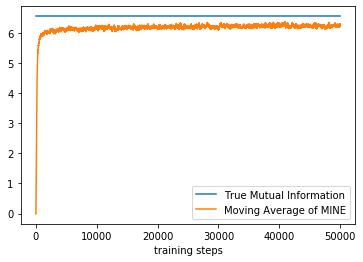

In [43]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 50000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), mv_av, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_5D_1.png')
fig.show()



error=((np.amax(mv_av)-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(np.amax(mv_av))
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, np.amax(mv_av), error)) 
op.close() 



C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


true value:
3.187094392249076
calculated value:
3.142345905303955
error
-2.4917389237815697




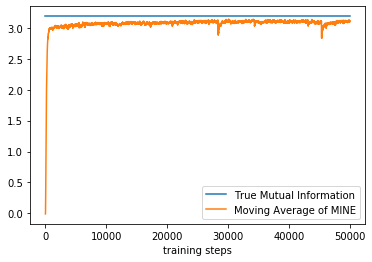

In [44]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 50000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av_2=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_2)), mv_av_2, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_5D_2.png')
fig.show()



error=((mv_av_2[-1]-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(np.amax(mv_av_2))
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, np.amax(mv_av_2), error)) 
op.close() 



C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


true value:
5.018562059654992
calculated value:
4.960610389709473
error
-1.1547465042108807




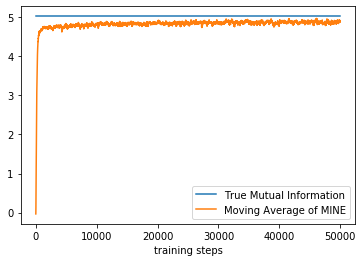

In [45]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 50000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av_3=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_3)), mv_av_3, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_5D_3.png')
fig.show()



error=((np.amax(mv_av_3)-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(np.amax(mv_av_3))
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, np.amax(mv_av_3), error)) 
op.close() 



C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


true value:
2.960122204030435
calculated value:
2.9391064643859863
error
-0.7099618933243375




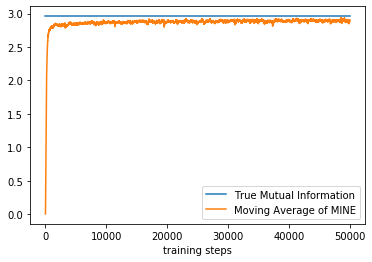

In [46]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 50000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av_4=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_4)), mv_av_4, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_5D_4.png')
fig.show()



error=((np.amax(mv_av_4)-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(np.amax(mv_av_4))
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, np.amax(mv_av_4), error)) 
op.close() 



C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


true value:
2.977907576181279
calculated value:
nan
error
nan




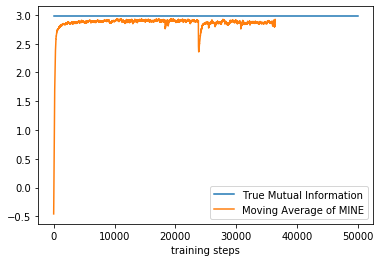

In [47]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 50000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av_5=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_5)), mv_av_5, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_5D_5.png')
fig.show()



error=((np.amax(mv_av_5)-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(np.amax(mv_av_5))
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, np.amax(mv_av_5), error)) 
op.close() 



In [48]:
print(list(mv_av_5))


[-0.45839738845825195, -0.45453348755836487, -0.448574960231781, -0.4416171610355377, -0.4336659908294678, -0.4249018132686615, -0.41553783416748047, -0.4050857722759247, -0.39390960335731506, -0.3819757103919983, -0.3687223196029663, -0.3547388017177582, -0.34021657705307007, -0.3253026604652405, -0.3098057210445404, -0.2938578128814697, -0.27734532952308655, -0.2603057622909546, -0.24324816465377808, -0.2265462875366211, -0.20893439650535583, -0.19253547489643097, -0.17602261900901794, -0.15871109068393707, -0.14151827991008759, -0.1251588761806488, -0.10785744339227676, -0.08969949930906296, -0.07286850363016129, -0.05604296177625656, -0.039439599961042404, -0.023114996030926704, -0.005252493545413017, 0.010265047661960125, 0.027472570538520813, 0.043841440230607986, 0.060311973094940186, 0.07782095670700073, 0.09367053955793381, 0.11051970720291138, 0.12716363370418549, 0.14371518790721893, 0.15909647941589355, 0.17519184947013855, 0.19107918441295624, 0.20737731456756592, 0.223215

In [21]:
print(list(mv_av_2))

[-0.008910596370697021, -0.008295712061226368, -0.007311290130019188, -0.005913650617003441, -0.004252965096384287, -0.002186502330005169, 0.00022139470092952251, 0.003087360877543688, 0.006539460271596909, 0.010084597393870354, 0.014019660651683807, 0.018669644370675087, 0.023973174393177032, 0.029525279998779297, 0.03609137237071991, 0.04269902780652046, 0.04962752014398575, 0.05771946534514427, 0.0665380209684372, 0.07564336061477661, 0.08528044819831848, 0.09552107751369476, 0.10751575231552124, 0.11968673765659332, 0.13268603384494781, 0.1474892646074295, 0.16156044602394104, 0.17601314187049866, 0.1930355727672577, 0.21015304327011108, 0.22782187163829803, 0.24532990157604218, 0.2610921561717987, 0.28024962544441223, 0.2993280589580536, 0.31880393624305725, 0.33786511421203613, 0.3572171628475189, 0.37563687562942505, 0.3947952389717102, 0.41435039043426514, 0.4356769323348999, 0.4558451771736145, 0.4773743748664856, 0.5000472664833069, 0.5212182998657227, 0.5416969656944275, 0.5